# Dataset

### Imports

In [19]:
import os
from functools import lru_cache
from subprocess import CalledProcessError, run
from typing import Optional, Union
import time
import copy

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchaudio

from sklearn.metrics import f1_score, precision_score, recall_score

from tqdm.auto import tqdm

### Connect G-Drive

In [4]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Paths

In [5]:
dir_main = "/content/gdrive/MyDrive/Penelitian: Birdsound_Classification/dataset_12"
dir_train = dir_main + "/train_grouped"
dir_test = dir_main + "/test_grouped"
dir_val = dir_main + "/val_grouped"

## Load Dataset

### Audio Processor Class

In [6]:
class AudioProcessor:
    def __init__(
        self,
        sample_rate: int = 48000,       # BirdNET typically uses 48kHz
        n_fft: int = 2048,              # Larger FFT for higher sample rate
        hop_length: int = 480,          # 10ms hops (48000 * 0.01)
        chunk_length: int = 3,          # 3-second chunks standard for BirdNET
        n_mels: int = 128,              # More mel bands for bioacoustics
        fmin: int = 500,                # Minimum frequency (birds are rarely below 500Hz)
        fmax: int = 15000,              # Maximum frequency (most birds below 15kHz)
        device: Optional[Union[str, torch.device]] = None
    ):
        """
        Initialize audio processor optimized for bird sound classification.

        Parameters:
            sample_rate: 48000 Hz recommended for bird sounds
            n_fft: FFT window size (2048 for 48kHz gives ~23ms windows)
            hop_length: 480 samples = 10ms at 48kHz
            chunk_length: 3 seconds standard for BirdNET
            n_mels: 128 mel bands captures bird sound details
            fmin/fmax: frequency range optimized for bird vocalizations
            device: torch device for computation
        """
        self.SAMPLE_RATE = sample_rate
        self.N_FFT = n_fft
        self.HOP_LENGTH = hop_length
        self.CHUNK_LENGTH = chunk_length
        self.N_MELS = n_mels
        self.FMIN = fmin
        self.FMAX = fmax

        # Derived parameters
        self.N_SAMPLES = self.CHUNK_LENGTH * self.SAMPLE_RATE  # 144000 samples for 3s@48kHz
        self.N_FRAMES = exact_div(self.N_SAMPLES, self.HOP_LENGTH)  # 300 frames (10ms each)

        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

        # Pre-compute mel filters
        self._mel_filters = self._create_mel_filters()

    def _create_mel_filters(self) -> torch.Tensor:
        """Create Mel filterbank optimized for bird sounds"""
        mel = torchaudio.transforms.MelScale(
            n_mels=self.N_MELS,
            sample_rate=self.SAMPLE_RATE,
            f_min=self.FMIN,
            f_max=self.FMAX,
            n_stft=self.N_FFT // 2 + 1
        ).to(self.device)
        return mel.fb

    def load_and_resample(self, file: str) -> torch.Tensor:
        """
        Load audio file and resample to target sample rate
        Returns:
            torch.Tensor: (1, n_samples) mono audio at self.SAMPLE_RATE
        """
        # Load with torchaudio (supports many formats)
        waveform, orig_sr = torchaudio.load(file)

        # Convert to mono if needed
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Resample if needed
        if orig_sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(
                orig_sr, self.SAMPLE_RATE
            ).to(self.device)
            waveform = resampler(waveform)

        return waveform

    def process_file(self, file: str) -> torch.Tensor:
        """
        Full processing pipeline for a single audio file:
        1. Load and resample
        2. Split into 3-second chunks
        3. Compute log-Mel spectrograms
        Returns:
            torch.Tensor: (n_chunks, n_mels, n_frames) spectrograms
        """
        waveform = self.load_and_resample(file)

        # Pad to multiple of chunk length
        pad_len = (self.N_SAMPLES - (waveform.shape[1] % self.N_SAMPLES)) % self.N_SAMPLES
        waveform = F.pad(waveform, (0, pad_len))

        # Split into 3-second chunks
        chunks = waveform.unfold(
            dimension=1,
            size=self.N_SAMPLES,
            step=self.N_SAMPLES  # No overlap
        )

        # Process each chunk
        specs = []
        for i in range(chunks.shape[1]):
            chunk = chunks[:, i]
            spec = self.log_mel_spectrogram(chunk)
            specs.append(spec)

        return torch.stack(specs)

    def log_mel_spectrogram(self, audio: torch.Tensor) -> torch.Tensor:
        """
        Compute log-Mel spectrogram optimized for bird sounds
        Input:
            audio: (1, n_samples) tensor
        Output:
            (n_mels, n_frames) spectrogram
        """
        # Compute STFT
        stft = torch.stft(
            audio,
            n_fft=self.N_FFT,
            hop_length=self.HOP_LENGTH,
            win_length=self.N_FFT,
            window=torch.hann_window(self.N_FFT).to(self.device),
            return_complex=True
        )

        # Compute power spectrum
        magnitudes = stft.abs() ** 2

        # Apply mel scaling
        mel_spec = self._mel_filters @ magnitudes.squeeze(0)

        # Log scaling with clipping
        log_spec = torch.log10(torch.clamp(mel_spec, min=1e-10))

        # Normalize (optional - adjust based on your data)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-6)

        return log_spec

In [13]:
class AudioProcessor:
    def __init__(
        self,
        sample_rate: int = 48000,
        n_fft: int = 2048,
        hop_length: int = 480,
        chunk_length: int = 3,
        n_mels: int = 128,
        fmin: int = 500,
        fmax: int = 15000,
        device: Optional[Union[str, torch.device]] = None
    ):
        self.SAMPLE_RATE = sample_rate
        self.N_FFT = n_fft
        self.HOP_LENGTH = hop_length
        self.CHUNK_LENGTH = chunk_length
        self.N_MELS = n_mels
        self.FMIN = fmin
        self.FMAX = fmax
        self.N_SAMPLES = self.CHUNK_LENGTH * self.SAMPLE_RATE
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize Mel filterbank
        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=self.N_MELS,
            sample_rate=self.SAMPLE_RATE,
            f_min=self.FMIN,
            f_max=self.FMAX,
            n_stft=self.N_FFT // 2 + 1
        ).to(self.device)

    def load_and_resample(self, file: str) -> torch.Tensor:
        waveform, orig_sr = torchaudio.load(file)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if orig_sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(
                orig_sr, self.SAMPLE_RATE
            ).to(self.device)
            waveform = resampler(waveform)

        return waveform

    def process_file(self, file: str) -> torch.Tensor:
        waveform = self.load_and_resample(file)

        # Pad if needed
        if waveform.shape[1] < self.N_SAMPLES:
            waveform = F.pad(waveform, (0, self.N_SAMPLES - waveform.shape[1]))
        else:
            # Take just the first 3 seconds if longer
            waveform = waveform[:, :self.N_SAMPLES]

        return self.log_mel_spectrogram(waveform)

    def log_mel_spectrogram(self, audio: torch.Tensor) -> torch.Tensor:
        # Compute STFT (shape will be [1, n_fft//2+1, time])
        stft = torch.stft(
            audio,
            n_fft=self.N_FFT,
            hop_length=self.HOP_LENGTH,
            win_length=self.N_FFT,
            window=torch.hann_window(self.N_FFT).to(self.device),
            return_complex=True
        ).squeeze(0)  # Remove batch dimension -> [freq, time]

        # Compute power spectrum
        magnitudes = stft.abs() ** 2

        # Apply mel scaling (expects [..., n_mels, time]
        mel_spec = self.mel_scale(magnitudes)  # [n_mels, time]

        # Log scaling with clipping and normalization
        log_spec = torch.log10(torch.clamp(mel_spec, min=1e-10))
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-6)

        return log_spec.unsqueeze(0)  # Add batch dimension -> [1, n_mels, time]

In [25]:
def visualize_audio_processing(file_path: str, processor: AudioProcessor):
    """
    Visualize the audio processing pipeline:
    1. Original waveform
    2. STFT spectrogram
    3. Mel spectrogram
    4. Log-Mel spectrogram

    Args:
        file_path: Path to audio file
        processor: Initialized AudioProcessor instance
    """
    # Load and process the audio
    waveform = processor.load_and_resample(file_path)
    log_mel_spec = processor.process_file(file_path)

    # Compute STFT for visualization
    stft = torch.stft(
        waveform.squeeze(0).to(processor.device),
        n_fft=processor.N_FFT,
        hop_length=processor.HOP_LENGTH,
        win_length=processor.N_FFT,
        window=torch.hann_window(processor.N_FFT).to(processor.device),
        return_complex=True
    )
    spectrogram = stft.abs().squeeze().cpu().numpy()

    # Convert tensors to numpy for plotting
    waveform = waveform.squeeze().cpu().numpy()
    log_mel_spec = log_mel_spec.squeeze().cpu().numpy()

    # Create time axis for waveform
    time = np.arange(waveform.shape[0]) / processor.SAMPLE_RATE

    # Create time and freq axes for spectrograms
    hop_time = processor.HOP_LENGTH / processor.SAMPLE_RATE
    spec_time = np.arange(spectrogram.shape[1]) * hop_time
    spec_freq = np.arange(spectrogram.shape[0]) * (processor.SAMPLE_RATE / 2) / (spectrogram.shape[0] - 1)

    mel_time = np.arange(log_mel_spec.shape[1]) * hop_time
    mel_freq = np.linspace(processor.FMIN, processor.FMAX, processor.N_MELS)

    # Create figure
    plt.figure(figsize=(15, 12))

    # Plot waveform
    plt.subplot(4, 1, 1)
    plt.plot(time, waveform)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.xlim(0, time[-1])

    # Plot spectrogram
    plt.subplot(4, 1, 2)
    plt.pcolormesh(spec_time, spec_freq, 10 * np.log10(spectrogram + 1e-10),
                  shading='auto', cmap='inferno')
    plt.title("STFT Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, processor.SAMPLE_RATE/2)
    plt.colorbar(label="dB")

    # Plot mel spectrogram (before log)
    mel_spec = processor.mel_scale(torch.from_numpy(spectrogram).to(processor.device)).cpu().numpy()
    plt.subplot(4, 1, 3)
    plt.pcolormesh(mel_time, mel_freq, mel_spec,
                  shading='auto', cmap='inferno')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(processor.FMIN, processor.FMAX)
    plt.colorbar(label="Magnitude")

    # Plot log-mel spectrogram
    plt.subplot(4, 1, 4)
    plt.pcolormesh(mel_time, mel_freq, log_mel_spec,
                  shading='auto', cmap='inferno')
    plt.title("Log-Mel Spectrogram (Normalized)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(processor.FMIN, processor.FMAX)
    plt.colorbar(label="Normalized dB")

    plt.tight_layout()
    plt.show()

In [26]:
processor = AudioProcessor()

# Process a file into 3-second chunks
specs = processor.process_file(dir_train + "/cinnyris jugularis/109957_0.mp3")
print(f"Processed {specs.shape[0]} chunks, spectrogram shape: {specs.shape[1:]}")

Processed 1 chunks, spectrogram shape: torch.Size([128, 301])


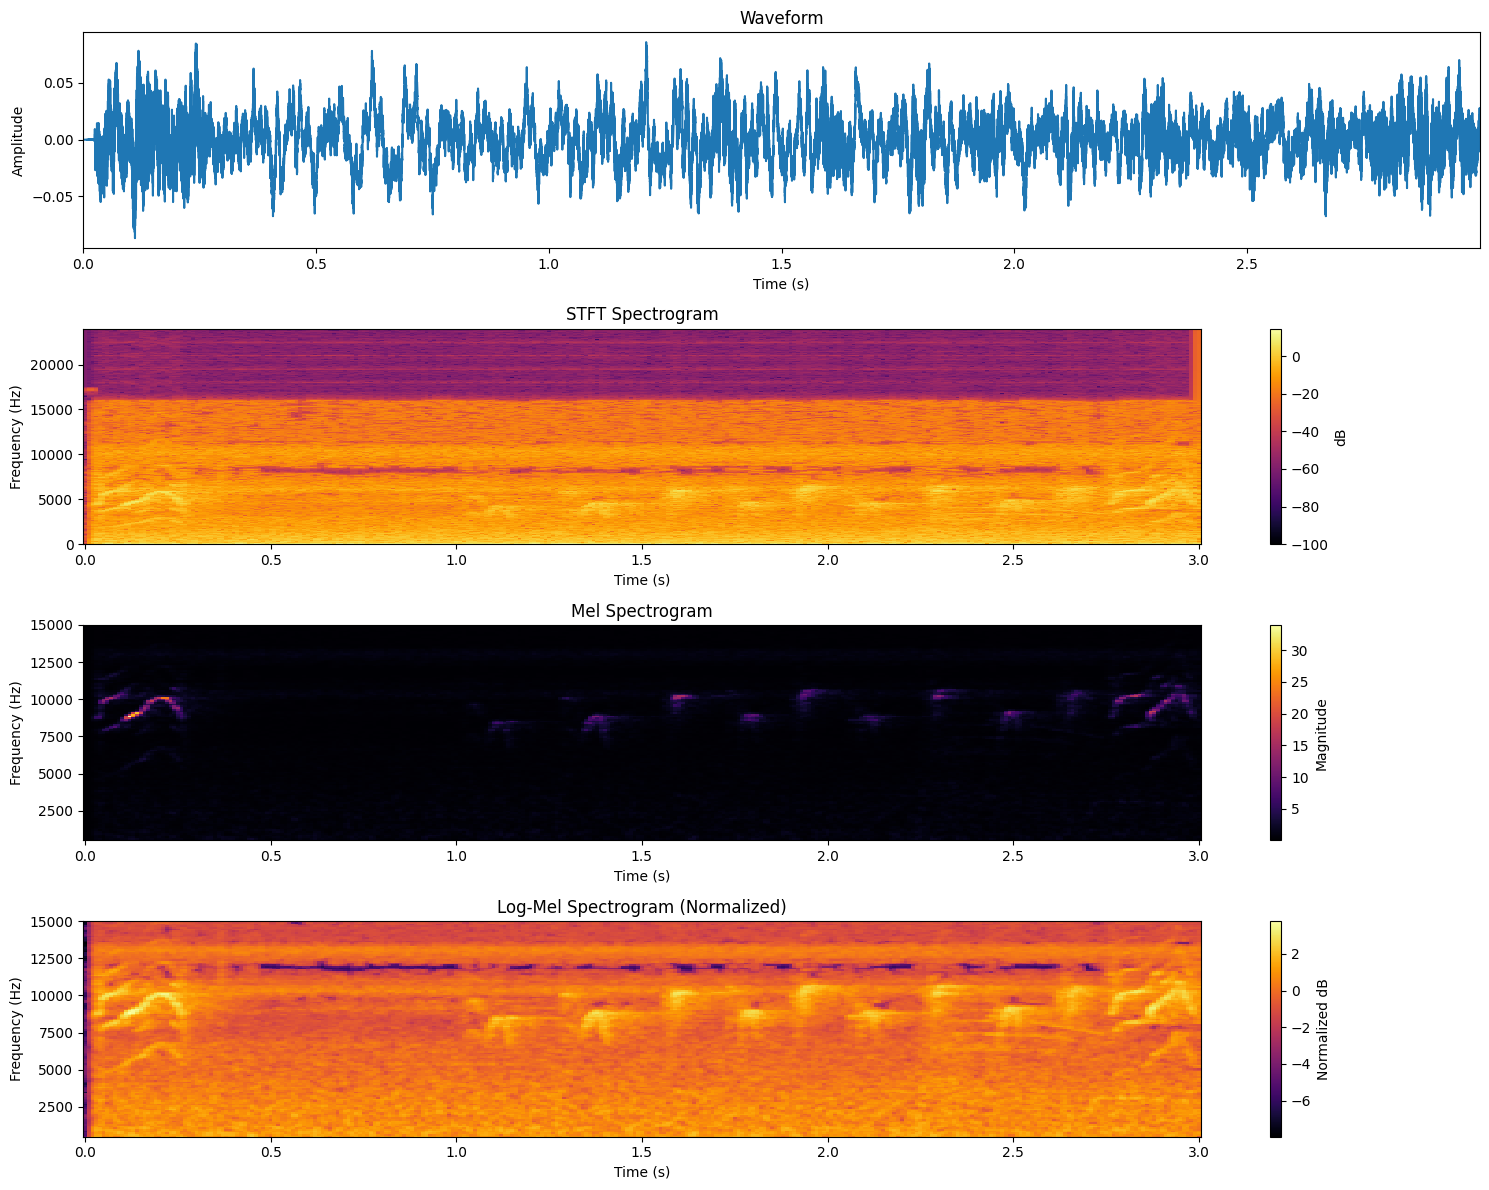

In [27]:
visualize_audio_processing(dir_train + "/cinnyris jugularis/109957_0.mp3", processor)

In [29]:
dataset_train = []

all_files = []
for folder in os.listdir(dir_train):
    folder_path = os.path.join(dir_train, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        all_files.append((file_path, folder))

for file_path, folder in tqdm(all_files, desc="Processing training files"):
    try:
        specs = processor.process_file(file_path)
        dataset_train.append((specs, folder))
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        continue

print(f"Processed {len(dataset_train)} files successfully")

Processing training files:   0%|          | 0/24085 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
dataset_val = []

all_files = []
for folder in os.listdir(dir_val):
    folder_path = os.path.join(dir_val, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        all_files.append((file_path, folder))

for file_path, folder in tqdm(all_files, desc="Processing validation files"):
    try:
        specs = processor.process_file(file_path)
        dataset_val.append((specs, folder))
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        continue

print(f"Processed {len(dataset_val)} files successfully")

# Model

### Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim: int, n_heads: int, dropout: float):
        super().__init__()
        self.attention = nn.MultiheadAttention(emb_dim, n_heads, dropout=dropout)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
            nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Self-attention
        attn_out, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_out)
        x = self.ln1(x)

        # Feed-forward
        mlp_out = self.mlp(x)
        x = x + self.dropout(mlp_out)
        x = self.ln2(x)

        return x

### Encoder

In [ ]:
class AudioEncoder(nn.Module):
    def __init__(
        self,
        n_mels: int = 128,               # From AudioProcessor.N_MELS
        sample_rate: int = 48000,        # From AudioProcessor.SAMPLE_RATE
        hop_length: int = 480,           # From AudioProcessor.HOP_LENGTH
        chunk_length: int = 3,           # From AudioProcessor.CHUNK_LENGTH
        n_fft: int = 2048,               # From AudioProcessor.N_FFT
        emb_dim: int = 768,              # Embedding dimension
        n_heads: int = 8,                # Number of attention heads
        n_layers: int = 6,               # Number of transformer layers
        conv_expansion: int = 2,         # Conv channel expansion factor
        dropout: float = 0.1             # Dropout rate
    ):
        super().__init__()

        # Calculate time dimension
        self.n_frames = (chunk_length * sample_rate) // hop_length

        # Convolutional preprocessing
        conv_channels = emb_dim * conv_expansion
        self.conv1 = nn.Conv1d(n_mels, conv_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, emb_dim, kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(dropout)

        # Positional embeddings
        self.register_buffer(
            "positional_embedding",
            self.sinusoidal_embedding(self.n_frames // 2, emb_dim)  # After stride=2
        )

        # Transformer layers
        self.transformer = nn.ModuleList([
            TransformerBlock(emb_dim, n_heads, dropout)
            for _ in range(n_layers)
        ])
        self.ln_final = nn.LayerNorm(emb_dim)

    def sinusoidal_embedding(length: int, dim: int, base: float = 10000.0) -> torch.Tensor:
        """Generate sinusoidal positional embeddings.

        Args:
            length: Sequence length
            dim: Embedding dimension (must be even)
            base: Frequency base constant

        Returns:
            Tensor of shape (length, dim) with positional encodings
        """
        if dim % 2 != 0:
            raise ValueError(f"Embedding dimension must be even, got {dim}")

        position = torch.arange(length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2, dtype=torch.float32) *
                    (-math.log(base) / dim))

        pe = torch.zeros(length, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Input:
            x: (batch_size, n_mels, n_frames) - log mel spectrogram
        Output:
            (batch_size, n_frames//2, emb_dim) - encoded features
        """
        # Conv processing
        x = F.gelu(self.conv1(x))
        x = self.dropout(x)
        x = F.gelu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)  # (batch, time, channels)

        # Add positional embeddings
        x = x + self.positional_embedding[:x.size(1)]

        # Transformer processing
        for layer in self.transformer:
            x = layer(x)

        return self.ln_final(x)

### Main Model

In [ ]:
class AudioModel(nn.Module):
    def __init__(self, processor_config: dict = None, model_config: dict = None):
        super().__init__()

        # Initialize processor with defaults or custom config
        self.processor = AudioProcessor(**(processor_config or {}))

        # Model configuration
        default_model_config = {
            'emb_dim': 768,
            'n_heads': 8,
            'n_layers': 6,
            'conv_expansion': 2,
            'dropout': 0.1
        }
        if model_config:
            default_model_config.update(model_config)

        # Initialize encoder
        self.encoder = AudioEncoder(
            n_mels=self.processor.N_MELS,
            sample_rate=self.processor.SAMPLE_RATE,
            hop_length=self.processor.HOP_LENGTH,
            chunk_length=self.processor.CHUNK_LENGTH,
            n_fft=self.processor.N_FFT,
            **default_model_config
        )

    def forward(self, audio_path: str) -> torch.Tensor:
        # Process audio file
        specs = self.processor.process_file(audio_path)

        # Encode features
        return self.encoder(specs)

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import time
import copy

In [ ]:
# ===================== CONFIGURATION =====================
# Training parameters
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 5  # For early stopping

# Model parameters (should match your AudioModel)
MODEL_CONFIG = {
    'emb_dim': 768,
    'n_heads': 8,
    'n_layers': 6,
    'conv_expansion': 2,
    'dropout': 0.1
}

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

In [ ]:
# ===================== DATA PREPARATION =====================
class AudioDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spec, label = self.data[idx]
        return spec.squeeze(0), torch.tensor(label, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = AudioDataset(dataset_train)
val_dataset = AudioDataset(dataset_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
# ===================== MODEL SETUP =====================
model = AudioModel(model_config=MODEL_CONFIG).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)  # Monitor validation F1

In [ ]:
# ===================== TRAINING FUNCTIONS =====================
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with tqdm(dataloader, unit="batch", desc="Training") as tepoch:
        for specs, labels in tepoch:
            specs, labels = specs.to(device), labels.to(device)

            # Forward pass
            outputs = model.encoder(specs)

            # Average over time dimension (alternative: use attention pooling)
            pooled = outputs.mean(dim=1)
            loss = criterion(pooled, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, preds = torch.max(pooled, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    epoch_acc = (np.array(all_preds) == np.array(all_labels)).mean()

    return epoch_loss, epoch_acc, epoch_f1

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        with tqdm(dataloader, unit="batch", desc="Validation") as tepoch:
            for specs, labels in tepoch:
                specs, labels = specs.to(device), labels.to(device)

                # Forward pass
                outputs = model.encoder(specs)
                pooled = outputs.mean(dim=1)
                loss = criterion(pooled, labels)

                # Metrics
                running_loss += loss.item()
                _, preds = torch.max(pooled, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update progress bar
                tepoch.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    epoch_acc = (np.array(all_preds) == np.array(all_labels)).mean()
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_recall = recall_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_acc, epoch_f1, epoch_precision, epoch_recall

In [ ]:
# ===================== TRAINING LOOP =====================
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
no_improve = 0

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'val_precision': [], 'val_recall': []
}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    start_time = time.time()

    # Train and validate
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_f1, val_prec, val_rec = validate(model, val_loader, criterion, DEVICE)

    # Update learning rate
    scheduler.step(val_f1)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    print(f"Precision: {val_prec:.4f} | Recall: {val_rec:.4f}")
    print(f"Time: {time.time()-start_time:.2f}s")

    # Early stopping and model checkpoint
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve = 0
        print("*** New best model ***")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"No improvement for {PATIENCE} epochs, stopping...")
            break

In [ ]:
# Load best model weights
model.load_state_dict(best_model_wts)
print(f"\nTraining complete. Best Validation F1: {best_f1:.4f}")

In [ ]:
# ===================== SAVE RESULTS =====================
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': MODEL_CONFIG,
    'history': history
}, 'birdnet_model.pth')

In [ ]:
# Plot training curves (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train')
plt.plot(history['val_f1'], label='Validation')
plt.title('F1 Score')
plt.legend()
plt.savefig('training_curves.png')
plt.close()